In [1]:
# Model Building
%%capture

!pip install pdpbox
!pip install shap
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap


In [2]:
path = 'framingham.csv'
df = pd.read_csv(path)
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
# Create Wrangle function for reproducibility.
path = 'framingham.csv'

def wrangle(filepath):

  df = pd.read_csv(filepath)

# Drop the column'education'.
  df.drop(['education'],axis=1,inplace=True)

# Rename column 'male' to 'gender'.

  df.rename(columns={'male':'gender'},inplace=True)

# Drop null values.
  df.dropna(axis = 0,inplace=True)

  return df 

df=wrangle(path)

df.head()

,gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
df.shape

(3749, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 4237
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           3749 non-null   int64  
 1   age              3749 non-null   int64  
 2   currentSmoker    3749 non-null   int64  
 3   cigsPerDay       3749 non-null   float64
 4   BPMeds           3749 non-null   float64
 5   prevalentStroke  3749 non-null   int64  
 6   prevalentHyp     3749 non-null   int64  
 7   diabetes         3749 non-null   int64  
 8   totChol          3749 non-null   float64
 9   sysBP            3749 non-null   float64
 10  diaBP            3749 non-null   float64
 11  BMI              3749 non-null   float64
 12  heartRate        3749 non-null   float64
 13  glucose          3749 non-null   float64
 14  TenYearCHD       3749 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 468.6 KB


In [6]:
df.isnull().sum()

gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [7]:
df.TenYearCHD.value_counts()

0    3177
1     572
Name: TenYearCHD, dtype: int64

In [8]:
# Split target vector from feature matrix.

target = 'TenYearCHD'
X = df.drop(target,axis=1)
y = df[target]

In [9]:
X.shape,y.shape

((3749, 14), (3749,))

In [10]:
y.value_counts(normalize=True)

0    0.847426
1    0.152574
Name: TenYearCHD, dtype: float64

In [11]:
# Split data into training and validation sets.

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)


In [12]:
# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Establish Baseline

This is Logistic Regression problem because the dependent variable is binary.Since this is a classification problem our baseline will be accuracy.

In [13]:
base_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', base_acc)

Baseline accuracy: 0.8492830943647882


Build Models

In [14]:
# Model 1: Logistic Regression

model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [15]:
# Model 2 Random Forest

model_rf = make_pipeline(
           SimpleImputer(),
           RandomForestClassifier(n_estimators=24, n_jobs=-1,random_state=42)                          

)
model_rf.fit(X_train,y_train);

Check Metrics

In [16]:
print('Training Accuracy:', model_lr.score(X_train, y_train))
print('Validation Accuracy:', model_lr.score(X_val, y_val))

Training Accuracy: 0.8549516505501834
Validation Accuracy: 0.844


In [17]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 0.9923307769256419
Validation Accuracy 0.8413333333333334


Precision, Recall, f1

              precision    recall  f1-score   support

     No Risk       0.85      0.99      0.91       630
        Risk       0.62      0.07      0.12       120

    accuracy                           0.84       750
   macro avg       0.73      0.53      0.52       750
weighted avg       0.81      0.84      0.79       750



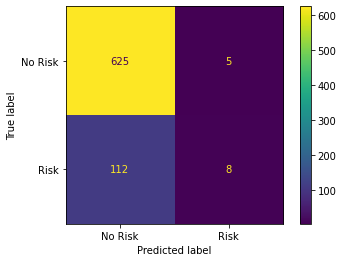

In [18]:
print(classification_report(y_val,
                            model_lr.predict(X_val),
                            target_names=['No Risk','Risk']))
                            
plot_confusion_matrix(model_lr,
                      X_val,
                      y_val,
                      values_format = '.0f',
                      display_labels=['No Risk','Risk'] )

The confusion matrix shows 633 correct predictions and 117 incorrect predictions.

              precision    recall  f1-score   support

     No Risk       0.85      0.99      0.91       630
        Risk       0.55      0.05      0.09       120

    accuracy                           0.84       750
   macro avg       0.70      0.52      0.50       750
weighted avg       0.80      0.84      0.78       750



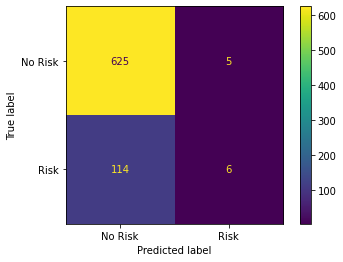

In [19]:
print(classification_report(y_val,
                            model_rf.predict(X_val),
                            target_names=['No Risk','Risk']))

plot_confusion_matrix(model_rf,
                      X_val,
                      y_val,
                      values_format = '.0f',
                      display_labels=['No Risk','Risk'])

The confusion matrix shows 631 correct predictions and 119 incorrect predictions

ROC CURVE

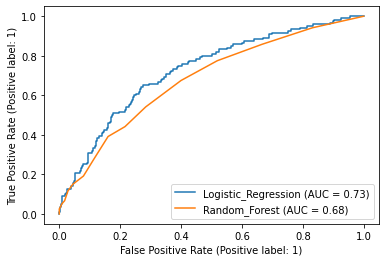

In [20]:
lr = plot_roc_curve(model_lr,
                    X_val,
                    y_val,
                    name = 'Logistic_Regression');

rf = plot_roc_curve(model_rf,
                    X_val,
                    y_val,
                    ax=lr.ax_,
                    name = 'Random_Forest');

In [21]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.7258465608465609

In [22]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.6795767195767195

Tune Model

In [24]:
train_acc = []
val_acc = []
samples = np.arange(.2, 1, 0.1)

for sample in samples:

  forest_model = make_pipeline(
      
      SimpleImputer(),
      RandomForestClassifier(max_samples=sample, n_estimators=20, random_state=42, n_jobs =-1)
  )

  forest_model.fit(X_train, y_train)
  train_acc.append(forest_model.score(X_train, y_train))
  val_acc.append(forest_model.score(X_val, y_val))

In [25]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 0.9923307769256419
Validation Accuracy 0.8413333333333334


In [26]:
# Model 3:XGBoost Model
model_xgb = XGBClassifier(random_state=42, n_jobs=-1) # This is for shap plots
model_xgb.fit(X_train, y_train);

In [27]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.873624541513838
Validation Accuracy 0.8453333333333334


Partial Dependence Plots

One Feature

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


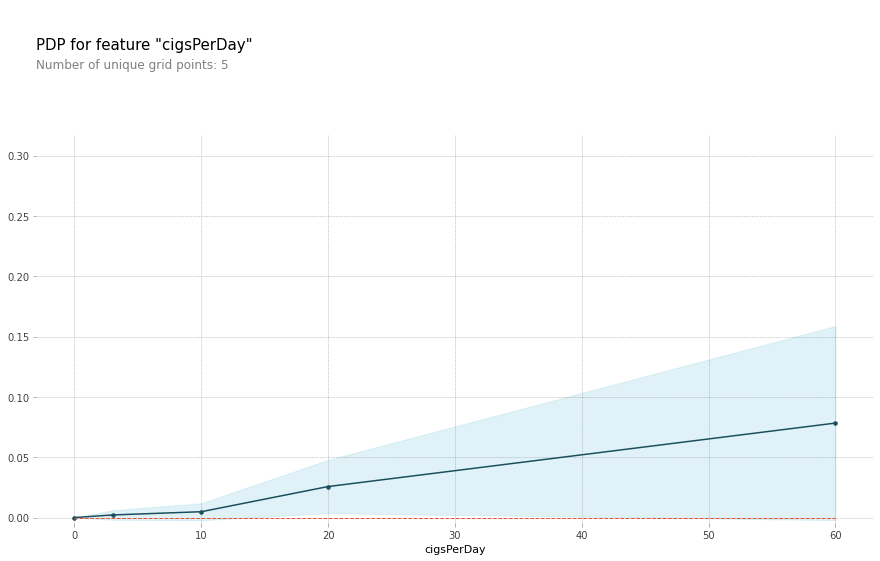

In [28]:
feature = 'cigsPerDay'
isolate = pdp_isolate(
          model_xgb,
          dataset = X_val,
          model_features = X_val.columns,
          feature = feature
)
pdp_plot(isolate,feature_name=feature);

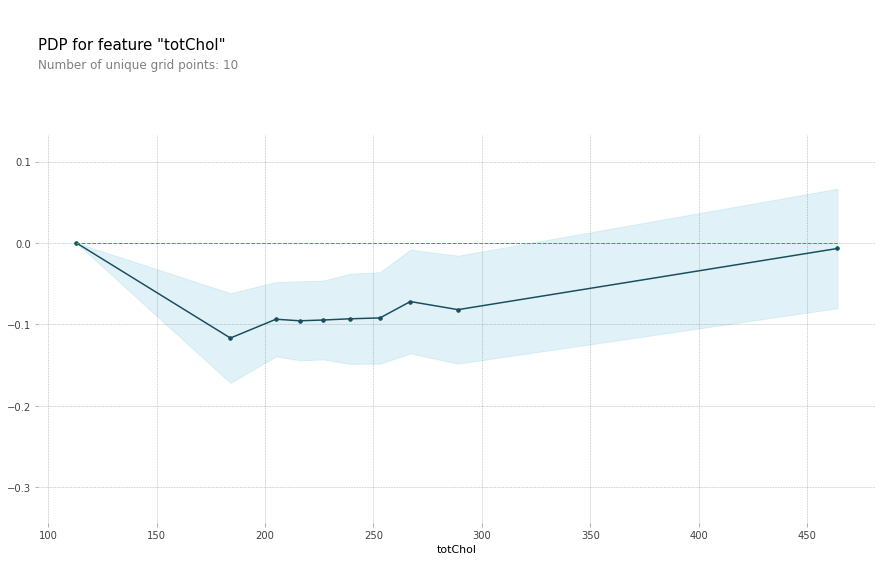

In [29]:
feature = 'totChol'
isolate = pdp_isolate(
          model_xgb,
          dataset = X_val,
          model_features = X_val.columns,
          feature = feature
)
pdp_plot(isolate,feature_name=feature);

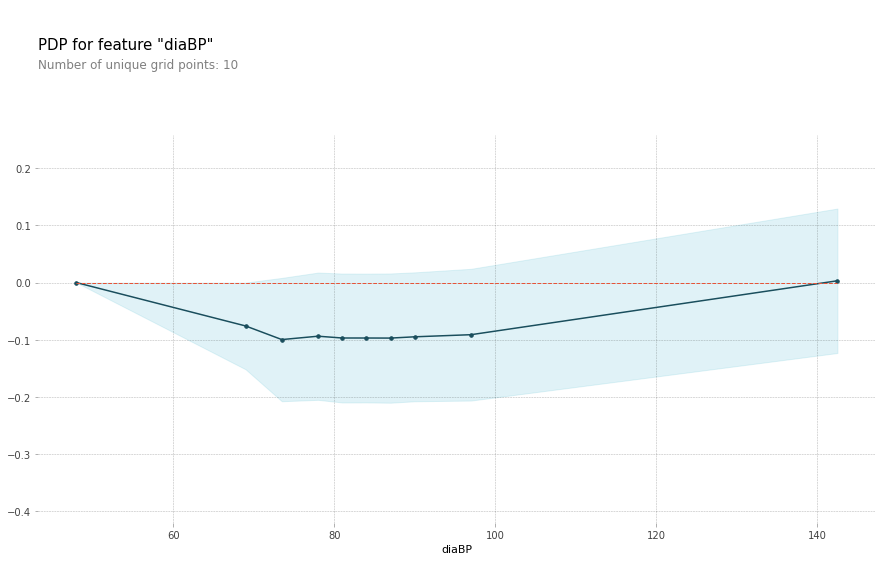

In [30]:
feature = 'diaBP'
isolate = pdp_isolate(
          model_xgb,
          dataset = X_val,
          model_features = X_val.columns,
          feature = feature
)
pdp_plot(isolate,feature_name=feature);

Two Features

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


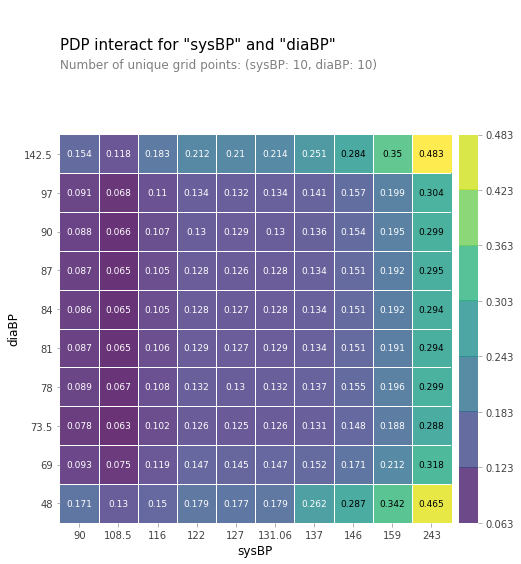

In [31]:
features = ['sysBP','diaBP']

interact = pdp_interact(
          model_xgb,
          dataset = X_val,
          model_features = X_val.columns,
          features = features
)
pdp_interact_plot(interact,plot_type='grid',feature_names=features);

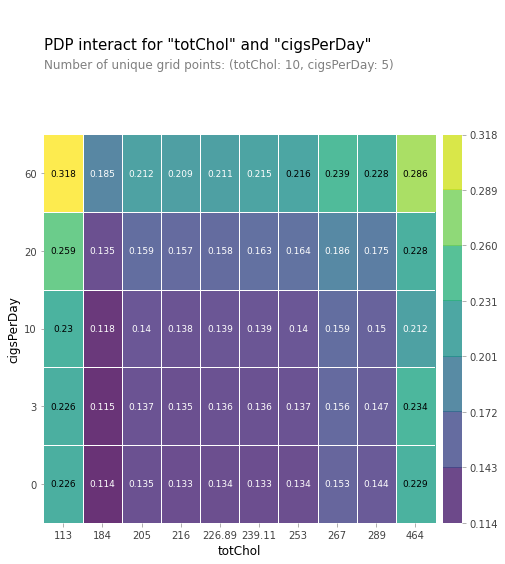

In [32]:
features = ['totChol','cigsPerDay']

interact = pdp_interact(
          model_xgb,
          dataset = X_val,
          model_features = X_val.columns,
          features = features
)
pdp_interact_plot(interact,plot_type='grid',feature_names=features);

Shapley Plots

In [33]:
sample_row = X_val.head(1)

In [34]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(sample_row)

In [35]:
shap_values

array([[-0.28511584,  0.1306558 ,  0.        ,  0.06478208, -0.00815389,
        -0.00254608,  0.0633224 ,  0.        ,  0.01484005, -0.09724049,
        -0.00058297, -0.12331193, -0.17887107, -0.12780279]],
      dtype=float32)

In [36]:
shap_values.shape

(1, 14)

In [37]:
# Shapley Force Plot

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=sample_row
)

In [38]:
shap_df = pd.DataFrame(data=shap_values[0],index=X_val.columns,columns=['shap_value'])
shap_df

,shap_value
gender,-0.285116
age,0.130656
currentSmoker,0.000000
cigsPerDay,0.064782
BPMeds,-0.008154
prevalentStroke,-0.002546
prevalentHyp,0.063322
diabetes,0.000000
totChol,0.014840
sysBP,-0.097240
